In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_datum(size):
    x = np.array([np.random.randint(0,10) for i in range(size)])
    r = np.random.binomial(1,0.5)
    if r:
        pos = np.random.randint(0,size)
        x[pos] = -1
    return x.reshape(-1,1),r

In [3]:
import torch
def make_data(N):
    size = np.random.randint(10,26)
    xy = [make_datum(size) for i in range(N)]
    X = np.array([x for x,y in xy])
    y = np.array([y for x,y in xy])
    return torch.FloatTensor(X),torch.FloatTensor(y.reshape(-1,1))

In [4]:
class RNN(torch.nn.Module):
    def __init__(self, rnn_cls = torch.nn.RNN):
        super().__init__()
        self.NH = 10
        self.rnn = rnn_cls(1,self.NH, batch_first = True, num_layers = 1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.NH,1),
            torch.nn.Sigmoid()
            )
    def forward(self,x):
        Y,H = self.rnn(x)
        out = self.mlp(Y)
        answer = out[:,-1,:]
        return answer,out

In [5]:
def train(rnn_cls):
    trajectory = []
    model = RNN(rnn_cls)
    opt = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(3000):
        X,y = make_data(100)
        p,HX = model(X)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        trajectory.append([i,float(loss),X.shape[1]])
        if i % 250 == 0:
            print(f"{i}: {float(loss)}")
    return model,np.array(trajectory)

print("LSTM:")
trained_lstm,traj_lstm = train(torch.nn.LSTM)
print("RNN:")
trained_rnn,traj_rnn = train(torch.nn.RNN)

LSTM:
0: 0.702009379863739
250: 0.5793688297271729
500: 0.2464955747127533
750: 0.06957600265741348
1000: 0.042610809206962585
1250: 0.025511987507343292
1500: 0.018439576029777527
1750: 0.008132686838507652
2000: 0.005651933141052723
2250: 0.00803183950483799
2500: 0.004213846754282713
2750: 0.0038666289765387774
RNN:
0: 0.7016966342926025
250: 0.6869896054267883
500: 0.645480751991272
750: 0.7043168544769287
1000: 0.4160635471343994
1250: 0.21255314350128174
1500: 0.25471073389053345
1750: 0.14327317476272583
2000: 0.0566554069519043
2250: 0.10322853177785873
2500: 0.04702906683087349
2750: 0.04868306219577789


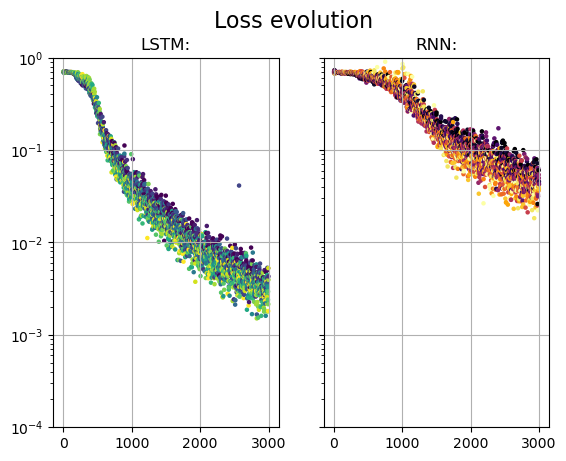

In [22]:
f,axarr = plt.subplots(1,2, sharey = True)
f.suptitle("Loss evolution",fontsize=16)
ax = axarr[0]
ax.scatter(traj_lstm[:,0],traj_lstm[:,1], c = traj_lstm[:,2], cmap = 'viridis', s = 5)
ax.set_yscale('log')
ax.set_ylim(1e-4,1)
ax.grid()
ax.title.set_text("LSTM:")

ax = axarr[1]
ax.scatter(traj_rnn[:,0],traj_rnn[:,1], c = traj_rnn[:,2], cmap = 'inferno', s = 5)
ax.set_yscale('log')
ax.set_ylim(1e-4,1)
ax.title.set_text("RNN:")
ax.grid()
plt.show()

In [26]:
def plot(X,lstm_model, rnn_model):
    X = torch.FloatTensor(X).reshape(1,-1,1)
    f,axarr = plt.subplots(3,1)
    ax = axarr[0]
    ax.imshow(X[:1].reshape(1,-1))

    ax = axarr[1]
    with torch.no_grad():
        a,output = lstm_model(X[:1])
    ax.imshow(output.numpy()[0].T, vmin = 0, vmax = 1)
    ax.set_title(f'lstm - {a[0,0]:.3f}')
    ax = axarr[2]
    with torch.no_grad():
        a,output = rnn_model(X[:1])
    ax.imshow(output.detach().numpy()[0].T, vmin = 0, vmax = 1)
    ax.set_title(f'rnn - {a[0,0]:.3f}')

    f.set_size_inches(4,4)
    f.set_tight_layout(True)
    plt.show()

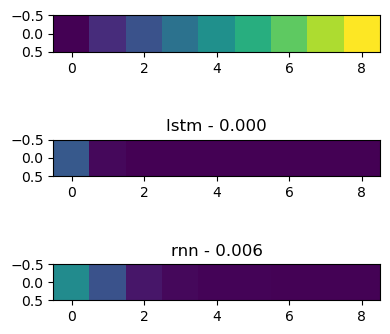

In [27]:
x = [[1,2,3,4,5,6,7,8,9]]
plot(x,trained_lstm,trained_rnn)

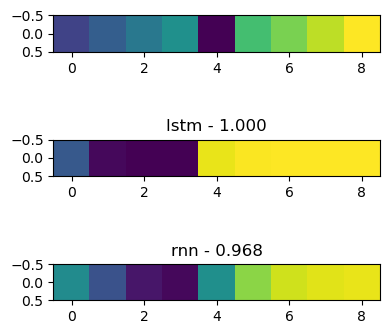

In [28]:
x = [[1,2,3,4,-1,6,7,8,9]]
plot(x,trained_lstm,trained_rnn)

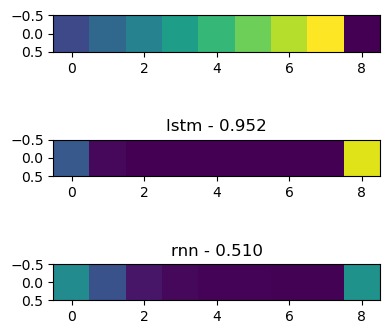

In [29]:
x = [[1,2,3,4,5,6,7,8,-1]]
plot(x,trained_lstm,trained_rnn)